# В этом ноутубке приведен процесс обучения контрольной и тестовой модели catboost, а также предобработка данных

In [1]:
# !pip install transformers psycopg2-binary
# import nltk
# nltk.download('popular')

In [ ]:
from transformers import AutoTokenizer 
from transformers import BertModel  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder
import warnings 
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

warnings.simplefilter('ignore')

## Создаем подключение к базе данных

In [ ]:
from sqlalchemy import Column, Integer, String, DateTime, create_engine, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, Session

DATABASE_URI = #URI ВАШЕЙ БД

engine = create_engine(DATABASE_URI)

inspector = inspect(engine) # чтобы подтянуть названия колонок

SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()

# создаем классы нашиих таблиц
class User_data(Base):
    __tablename__ = 'user_data'
    user_id = Column(Integer,primary_key=True)
    age = Column(Integer)
    city = Column(String)
    country = Column(String)
    exp_group = Column(Integer)
    gender = Column(String)
    os = Column(String)
    source = Column(String)

class Post(Base):
    __tablename__ = 'posts'
    id = Column(Integer, primary_key=True)
    text = Column(String)
    topic = Column(String)

class Feed_data(Base):
    __tablename__ = 'feed_data'
    timestamp = Column(DateTime, primary_key=True)
    user_id = Column(Integer)
    post_id = Column(Integer)
    action = Column(String)
    target = Column(Integer)

if __name__ == "__main__":
    Base.metadata.create_all(engine)


## Создадим вспомогательные функции для выгрузки данных

In [ ]:

def get_data_with_psycopg(query: str):
    '''с помощью SQL запроса через библиотеку pcycopg2
возвращает резульат запроса в виде numpy.ndarray'''

    conn = psycopg2.connect(DATABASE_URI)
    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    
    columns = [desc[0] for desc in cursor.description]
    
    cursor.close()
    conn.close()

    return pd.DataFrame(data=result,
                        columns=columns)

def get_data_with_sqlalchemy(table_name: str, limit):
    '''С помощью SQLAlchemy и указанием таблица и лимита
возвращает таблицу из базы с заданным лимитом
user_data
posts
feed_data'''

    table_dict = {
            'user_data': User_data,
            'posts': Post,
            'feed_data': Feed_data
            }
    table = table_dict[table_name]

    with SessionLocal() as session:
        data_from_db = session.query(table).limit(limit).all()

    columns_name = [column['name'] for column in inspector.get_columns(table_name)]
    
    return pd.DataFrame([item.__dict__ for item in data_from_db])[columns_name]




## Производим предобработку текстов

In [ ]:
# данные про посты
posts_df = get_data_with_sqlalchemy('posts', 200000)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Удаляем лишние символы
def del_symbols(text):
    text = text.replace('\n\n', ' ').replace('\n', ' ') # заменяем символы переноса строки на пробел
    text = re.sub(r'[^a-zA-Z\s]', '', text) # убираем все символы кроме букв и пробелов
    text = text.lower() # приводим к нижнему регистру
    
    return text
    
    
posts_df['text'] = posts_df['text'].apply(del_symbols)

# Удаляем стоп-слова
stop_words = stopwords.words('english')

def del_stopwords(text):
    important_words = [word for word in text.split() if word not in stop_words]
    
    return ' '.join(important_words)


posts_df['text'] = posts_df['text'].apply(del_stopwords)

# Лемматизируем слова
wnl = WordNetLemmatizer()

def lemmatize(text):
    lemm_words = [wnl.lemmatize(word) for word in text.split()]
    
    return ' '.join(lemm_words)

posts_df['text'] = posts_df['text'].apply(lemmatize)

posts_df['text'][0]

'uk economy facing major risk uk manufacturing sector continue face serious challenge next two year british chamber commerce bcc said group quarterly survey company found export picked last three month best level eight year rise came despite exchange rate cited major concern however bcc found whole uk economy still faced major risk warned growth set slow recently forecast economic growth slow little manufacturer domestic sale growth fell back slightly quarter survey firm found employment manufacturing also fell job expectation lowest level year despite positive news export sector worrying sign manufacturing bcc said result reinforce concern sector persistent inability sustain recovery outlook service sector uncertain despite increase export order quarter bcc noted bcc found confidence increased quarter across manufacturing service sector although overall failed reach level start reduced threat interest rate increase contributed improved confidence said bank england raised interest rate

In [ ]:
del wnl, stop_words

## Обучим две модели: 
* #### Kонтрольную - признаки для текстов генерируем из TF-IDF (кластеризация с помощью KMeans)
* #### Тестовую - признаки для текстов получаем из ебмедингов (BERT, кластеризация через DBSCAN и KMeans + фичи из TF-IDF)

### Генерируем признаки из TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# начнем с более простой модели

tf_idf = TfidfVectorizer().fit(posts_df['text'])

# создаем tf-idf индексы для текстов 
tfidf_dataframe = pd.DataFrame(tf_idf.transform(posts_df['text']).todense(),
                                columns=tf_idf.get_feature_names_out())

centered = tfidf_dataframe - tfidf_dataframe.mean()

# Уменьшаем размерность 
pca_from_tf_idf = PCA(n_components=50).fit_transform(centered)

# Получем главные компоненты нашему датафрейму
pca_from_tf_idf.shape

(7023, 50)

In [ ]:
del tf_idf, centered, tfidf_dataframe

In [ ]:
# кластеризуем тектсы по главным компонентам tf-idf
kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_from_tf_idf)

features_from_tfidf = pd.DataFrame(data=kmeans.transform(pca_from_tf_idf),
                                   columns=[f'DistanceTo{cls}thCluster' for cls in set(kmeans.labels_)])
   
features_from_tfidf['tf_idf_cluster'] = kmeans.labels_


features_from_tfidf.head()

,DistanceTo0thCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,tf_idf_cluster
0,0.568288,0.494819,0.484144,0.467039,0.742082,0.435568,0.477524,0.500803,0.236901,0.494693,0.523112,0.531333,0.553630,0.567747,0.508426,8
1,0.360190,0.392804,0.375488,0.350969,0.656370,0.278803,0.366721,0.400354,0.372434,0.400347,0.426981,0.432735,0.466252,0.488945,0.404584,5
2,0.534247,0.418502,0.401040,0.381478,0.703394,0.323575,0.405072,0.447916,0.291734,0.426937,0.473595,0.454045,0.496919,0.504313,0.429195,8
3,0.535005,0.424678,0.421502,0.394513,0.660801,0.339783,0.419139,0.464036,0.420461,0.454686,0.485748,0.473201,0.490407,0.486688,0.449211,5
4,0.402325,0.220881,0.202728,0.145537,0.596088,0.144861,0.244930,0.293189,0.325122,0.265523,0.318916,0.295413,0.332476,0.361297,0.259201,5


In [ ]:
one_hot_topics = pd.get_dummies(posts_df['topic'], drop_first=True)

processed_posts = pd.concat((posts_df['id'], 
                             features_from_tfidf,
                             one_hot_topics), axis=1).rename(columns={'id':'post_id'})

processed_posts.head()

,post_id,DistanceTo0thCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,...,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,tf_idf_cluster,covid,entertainment,movie,politics,sport,tech
0,1,0.568288,0.494819,0.484144,0.467039,0.742082,0.435568,0.477524,0.500803,0.236901,...,0.553630,0.567747,0.508426,8,0,0,0,0,0,0
1,2,0.360190,0.392804,0.375488,0.350969,0.656370,0.278803,0.366721,0.400354,0.372434,...,0.466252,0.488945,0.404584,5,0,0,0,0,0,0
2,3,0.534247,0.418502,0.401040,0.381478,0.703394,0.323575,0.405072,0.447916,0.291734,...,0.496919,0.504313,0.429195,8,0,0,0,0,0,0
3,4,0.535005,0.424678,0.421502,0.394513,0.660801,0.339783,0.419139,0.464036,0.420461,...,0.490407,0.486688,0.449211,5,0,0,0,0,0,0
4,5,0.402325,0.220881,0.202728,0.145537,0.596088,0.144861,0.244930,0.293189,0.325122,...,0.332476,0.361297,0.259201,5,0,0,0,0,0,0


In [ ]:

# старые функции предобработки данных
def users_processing(input_data):
    '''кодирует категориальные фичи,
       те что имеют менее 15 уникальных значений через OneHotEncoding,
       остальные через LabelEncoder
    '''
    df = input_data.copy()

    for col in df.columns:
        if df[col].dtype == 'O':
            if df[col].nunique() < 15:
                ohe_col = pd.get_dummies(df[col], drop_first=True)
                df = pd.concat((df, ohe_col), axis=1)
                df.drop(col, axis=1, inplace=True)
            else:
                df[col] = LabelEncoder().fit_transform(df[col])
                
    return df


def feed_processing(input_data):
    df = input_data.copy()
    df = df.groupby(['user_wid', 'post_id'], as_index=False).sum()
    df['target'] = df['target'].apply(lambda x: int(x > 0))
    
    return df


In [ ]:
user_processed = users_processing(get_data_with_sqlalchemy('user_data', 200000))
user_processed.head()

,user_id,gender,age,city,exp_group,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,Turkey,Ukraine,iOS,organic
0,200,1,34,651,3,0,0,0,0,0,0,1,0,0,0,0,0
1,201,0,37,2,0,0,0,0,0,0,0,1,0,0,0,0,0
2,202,1,17,2931,4,0,0,0,0,0,0,1,0,0,0,0,0
3,203,0,18,1953,1,0,0,0,0,0,0,1,0,0,0,1,0
4,204,0,36,125,3,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
feed_df = get_data_with_psycopg("select * from public.feed_data where (timestamp::date > '2021-11-01') and (timestamp::date < '2021-11-15') limit 3000000")
feed_df.shape

(3000000, 5)

In [ ]:
feed_processed = feed_processing(feed_df)
del feed_df

feed_processed.head()

,user_id,post_id,target
0,200,28,0
1,200,405,0
2,200,472,1
3,200,858,0
4,200,992,1


In [ ]:
concat_df = feed_processed.merge(user_processed, how='inner', on='user_id')
concat_df = concat_df.merge(processed_posts, how='inner', on='post_id')

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

X = concat_df.drop(['user_id', 'post_id', 'target'], axis=1)
y = concat_df['target']


test_size = 0.25
train_size = int(X.shape[0] - (X.shape[0] * test_size))

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:]

cat_columns = ['city', 'exp_group', 'tf_idf_cluster']

In [ ]:
# control_catboost = CatBoostClassifier(
#     learning_rate=0.9,
#     depth=2,
#     random_seed=138,
#     thread_count=-1,
#     task_type="GPU",
# )

# control_catboost.fit(X_train, y_train, 
#                      cat_features=cat_columns,
#                      verbose=True,
#                      eval_set=(X_test, y_test))


### Определяем функцию для рассчета Hitrate



In [ ]:
def get_hitrate(model):
    X_test['pred'] = model.predict_proba(X_test)[:,1]
    X_test['target'] = y_test
    X_test['user_id'] = concat_df[train_size:]['user_id']
    X_test['post_id'] = concat_df[train_size:]['post_id']

    model_hitrate = []
    for user in X_test['user_id'].unique():
        part = X_test[X_test['user_id'] == user].sort_values(by='pred', ascending=False) # сортируем по убыванию вероятностей
        part = part[:5] # получаем топ 5 постов, с наибольшей предсказанной вероятностью лайка
        
        hitrate = int(part['target'].sum() > 0) # считаем hitrate
        model_hitrate.append(hitrate)
    
    X_test.drop(['user_id', 'post_id','pred','target'],axis=1, inplace=True)
    
    return model_hitrate

In [ ]:
hitrate = np.mean(get_hitrate(control_catboost))
print(f'Hitrate контрольной модели : {hitrate}')

Hitrate контрольной модели : 0.5121957764241822


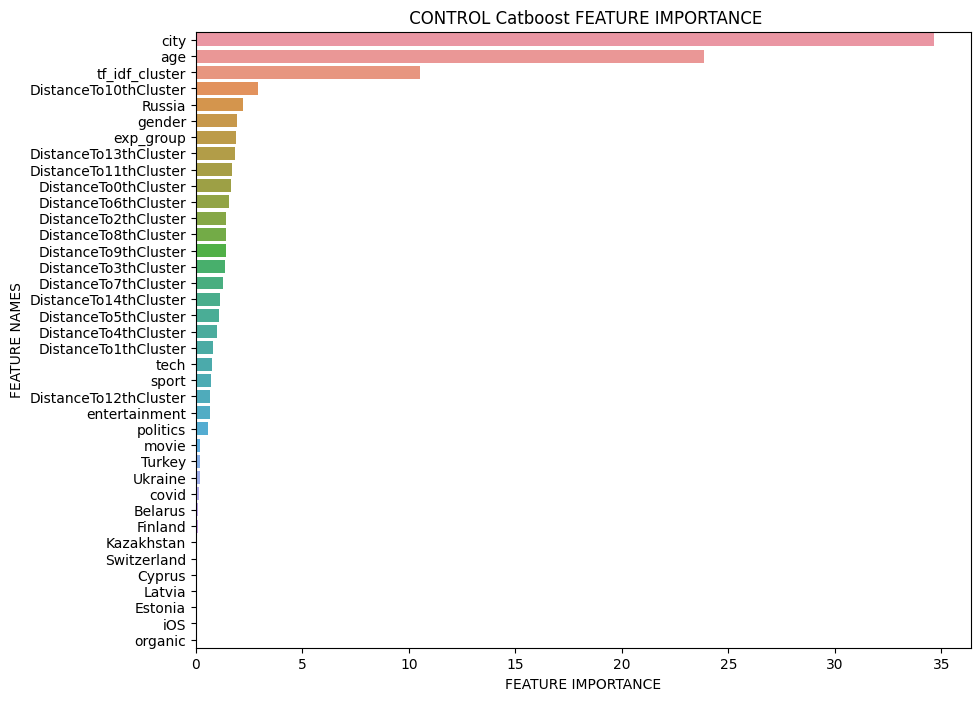

In [ ]:

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(control_catboost.feature_importances_,X_train.columns,' CONTROL Catboost')

In [ ]:
# сохраняем модель 
control_catboost.save_model(
    'control_catboost',
    format="cbm"                  
)

In [ ]:
#чистим память
del control_catboost, concat_df

##### теперь обучим модель на ембедингах, их получим с помощью предобученной BERT

### Получаем ембединги тектов и достаем из них фичи 

In [ ]:
# скачиваем предобученную BERT для получения ембедингов
tokenizer, model = AutoTokenizer.from_pretrained('bert-base-cased'), BertModel.from_pretrained('bert-base-cased')

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


# создаем датасет для постов
class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(posts_df['text'].values.tolist(), tokenizer)# токенизируем слова

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # для приведения текстов к одинаковой длинне

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False) 

In [ ]:
import torch
from tqdm import tqdm


@torch.inference_mode()# отключаем расчет градиента
def get_embeddings_labels(model, loader):
    '''Получаем ембединги с помощью модели'''

    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

model = model.to(device)

In [ ]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings.shape

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

centered = embeddings - embeddings.mean()

# понижаем размерность ембедингов
pca = PCA(n_components=50)
pca_decomp = pca.fit_transform(centered)

# кластеризуем главные компоненты с помощью KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

# кластеризуем ембединги без понижения размерности 
dbscan = DBSCAN(eps=3).fit(embeddings)

dists_columns = [f'DistanceToCluster_{i}' for i in range(15)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns)

dists_df['dbscan_clusters'] = dbscan.labels_
dists_df['kmeans_clusters'] = kmeans.labels_

print(f'Процент учтенной дисперсии : {round(sum(pca.explained_variance_ratio_) * 100,2)}%')

dists_df.head()


Процент учтенной дисперсии : 81.55%


,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,dbscan_clusters,kmeans_clusters
0,4.885947,4.013694,5.337161,3.430961,3.240476,4.209159,2.816814,4.347605,4.109518,4.938419,4.865866,5.404190,2.719312,5.314539,4.085820,0,12
1,7.365650,3.020405,7.915510,3.825038,4.929397,3.662909,4.059135,3.593085,1.825140,7.438226,7.086548,7.781630,4.947154,7.696849,6.242952,0,8
2,6.284945,2.226304,6.896920,4.518049,4.645065,2.784708,4.887888,5.230785,3.577348,6.578009,6.213522,6.460222,4.739002,6.772172,5.278029,-1,1
3,6.395127,4.953006,6.260554,3.058060,4.296948,5.105387,2.023567,2.815803,4.225357,6.208570,6.028819,6.350999,3.611956,6.675318,4.971673,0,6
4,4.295673,3.721398,4.691410,2.452093,2.493927,3.529050,2.841935,4.032390,3.755685,4.342939,4.044037,4.484669,1.892438,4.712291,3.033411,0,12


In [ ]:
# чистим память, чтобы побольше влезло
del model
del tokenizer
del dbscan
del kmeans
del pca
del dataset
del loader
del data_collator
del embeddings
del centered
del pca_decomp

In [ ]:
one_hot_topics = pd.get_dummies(posts_df['topic'], drop_first=True)

In [ ]:
posts_processed = pd.concat((posts_df['id'],
                             dists_df, # кластеризованные ембединги 
                             features_from_tfidf, # кластеризованные tf-idf
                             one_hot_topics),
                            axis=1)

posts_processed.rename(columns={'id':'post_id'}, inplace=True)
posts_processed.head()

,post_id,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,...,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,tf_idf_cluster,covid,entertainment,movie,politics,sport,tech
0,1,4.885947,4.013694,5.337161,3.430961,3.240476,4.209159,2.816814,4.347605,4.109518,...,0.429785,0.153237,0.466340,13,0,0,0,0,0,0
1,2,7.365650,3.020405,7.915510,3.825038,4.929397,3.662909,4.059135,3.593085,1.825140,...,0.311248,0.450197,0.302953,14,0,0,0,0,0,0
2,3,6.284945,2.226304,6.896920,4.518049,4.645065,2.784708,4.887888,5.230785,3.577348,...,0.235805,0.356460,0.390229,12,0,0,0,0,0,0
3,4,6.395127,4.953006,6.260554,3.058060,4.296948,5.105387,2.023567,2.815803,4.225357,...,0.291078,0.478927,0.402043,12,0,0,0,0,0,0
4,5,4.295673,3.721398,4.691410,2.452093,2.493927,3.529050,2.841935,4.032390,3.755685,...,0.165289,0.390245,0.230778,8,0,0,0,0,0,0


In [ ]:
# создаем датафрейм для обучения
concat_df = feed_processed.merge(user_processed, how='inner', on='user_id')
concat_df = concat_df.merge(posts_processed, how='inner', on='post_id')


In [ ]:
print(concat_df.shape)
concat_df.head()

(2625384, 58)


,user_id,post_id,target,gender,age,city,exp_group,Belarus,Cyprus,Estonia,...,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,tf_idf_cluster,covid,entertainment,movie,politics,sport,tech
0,3778,34,0,0,25,1524,2,0,0,0,...,0.365419,0.332584,0.329305,14,0,0,0,0,0,0
1,3853,34,0,0,26,2683,4,0,0,0,...,0.365419,0.332584,0.329305,14,0,0,0,0,0,0
2,3885,34,1,1,25,1642,1,0,0,0,...,0.365419,0.332584,0.329305,14,0,0,0,0,0,0
3,3916,34,0,1,25,2703,2,0,0,0,...,0.365419,0.332584,0.329305,14,0,0,0,0,0,0
4,4152,34,0,0,20,3427,2,0,0,0,...,0.365419,0.332584,0.329305,14,0,0,0,0,0,0


In [ ]:
from catboost import CatBoostClassifier


X = concat_df.drop(['user_id', 'post_id', 'target'], axis=1)
y = concat_df['target']

test_size = 0.25
train_size = int(X.shape[0] - (X.shape[0] * test_size))

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:]

cat_columns = ['city','exp_group', 'dbscan_clusters', 'kmeans_clusters']


In [ ]:

# test_catboost = CatBoostClassifier(
#     learning_rate=0.95,
#     depth=2,
#     random_seed=132,
#     thread_count=-1,
#     task_type="GPU"
# )

# test_catboost.fit(X_train, y_train, 
#                      cat_features=cat_columns,
#                      verbose=True,
#                      eval_set=(X_test, y_test))


In [ ]:
hitrate = np.mean(get_hitrate(test_catboost))
print(f'Hitrate тестовой модели : {hitrate}')

Hitrate тестовой модели : 0.5272628135223555


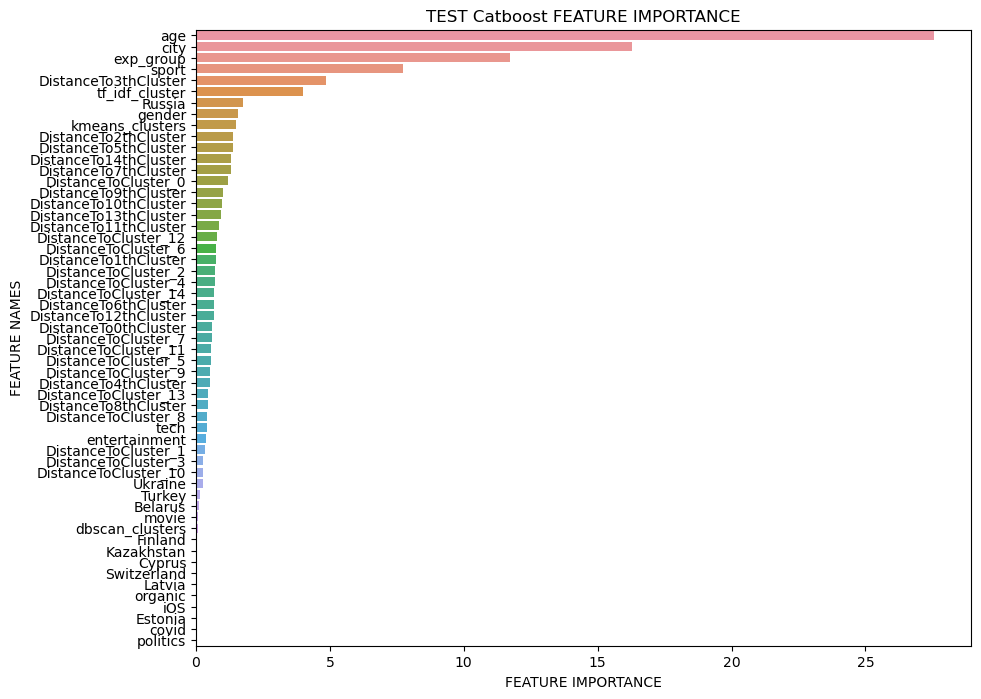

In [ ]:

plot_feature_importance(test_catboost.feature_importances_,X_train.columns,'TEST Catboost')

In [ ]:
test_catboost.save_model(
    'test_catboost',
    format="cbm"                  
)